In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functions as fs
import math
from IPython.display import display, Markdown, Latex

## Sommaire <a id="sommaire">
  - [Préparation de données](#preparation-de-donnees)
    - [population](#population)
    - [animaux](#animaux)
    - [végétaux](#vegetaux)
    - [céréales](#cereales)
    - [nombre de personnes sous alimentés](#nb-prsn-ss-alm)
    - [produits DataFrame](#pays-produits)
    - [produit_element DataFrame : Pivot produit](#pays-produit-pt)
        - [Etudes des valeurs Null, NaN](#prod-elem-nan)
  - [Questions](#questions)
    - [question 1](#question-1)
    - [question 2](#question-2)
    - [question 3](#question-3)
    - [question 4](#question-4)
    - [question 5](#question-5)
    - [question 6](#question-6) 
    - [question 7](#question-7)
    - [question 8](#question-8)
    - [question 9](#question-9)
    - [question 10](#question-10)
    - [question 11](#question-11)
    - [question 12](#question-12)
    - [question 13](#question-13)
    - [question 14](#question-14)

# Préparation de données  <a id="preparation-de-donnees" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>


### Population  <a id="population" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

In [140]:
pop_df = pd.read_csv('datas/population_13.csv')

In [141]:
pop_df[pop_df['Country'].str.contains('hin')][['Country Code', 'Country', 'Value']]

,Country Code,Country,Value
32,96,"China, Hong Kong SAR",7204
33,128,"China, Macao SAR",566
34,41,"China, mainland",1385567
35,214,"China, Taiwan Province of",23330
174,351,China,1416667


#### Redondance de la Chine

<div class="alert alert-warning">
**ATENTION** : Chaque provinces de chines est considéré comme un pays.
la population de la chine est donc compté deux fois
</div>

In [142]:
# on supprime la Chine (mais on garde ses provinces)
pop_df = pop_df[pop_df['Country Code'] != 351]

#### clefs primaires

In [143]:
print('clefs primaires : ')
for col in pop_df.columns:
    if fs.isPrimaryKey(pop_df, [col]):
        print("'{}'".format(col), end=', ')

clefs primaires : 
'Country Code', 'Country', 'Value', 

 <div class="alert alert-info">
     **Country Code** est la meilleurs clefs primaire
 </div>


#### DataFrame plus petit
Contient le code pays et la population

In [144]:
pop_small_df = pop_df[['Country Code', 'Value']].copy()
pop_small_df.columns = ['Code Pays', 'pop']
pop_small_df.loc[:, 'pop'] *= 1000

### Animaux  <a id="animaux" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

In [145]:
# animaux
anim_df = pd.read_csv('datas/animal_13.csv')
anim_df['origine'] = 'animal'

In [25]:
anim_df.shape

(37166, 15)

#### Redondance de la Chine

In [2]:
# on supprime la Chine (mais on garde ses provences)
anim_df = anim_df[anim_df['Code Pays'] != 351]

NameError: name 'anim_df' is not defined

#### Remarques sur les valeurs

In [147]:
display(Markdown(f"""
<div class="alert alert-info">
- Il y a **{len(anim_df[anim_df.Valeur == 0]) / len(anim_df) * 100:.0f}%** de valeurs égal a 0.
<br>
- Tout les éléments ont des valeurs égals a 0 ?
**{len(anim_df[anim_df.Valeur == 0]['Élément'].unique()) == len(anim_df['Élément'].unique())}**

<br>
- Il y a des valeurs `null` ? 
**{anim_df.isnull().sum().sum() != 0}**
</div>
"""))



<div class="alert alert-info">
- Il y a **37%** de valeurs égal a 0.
<br>
- Tout les éléments ont des valeurs égals a 0 ?
**True**

<br>
- Il y a des valeurs `null` ? 
**False**
</div>


#### Clefs primaires

il y a plusieurs **pays**.
  Pour chaques pays, il y a plusieurs **produits**.
  Pour chaque produits, il y a plusieurs **éléments**
  
<div class="alert alert-info">  
**Code Pays, Code Produit, Code Élément** est donc une **clef primaire**
</div>

### Végétaux <a id="vegetaux" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

In [148]:
vege_df = pd.read_csv('datas/vegetal_13.csv')
vege_df['origine'] = 'vegetal'

#### redondance de la Chine

In [149]:
# on supprime la Chine (mais on garde ses provences)
vege_df = vege_df[vege_df['Code Pays'] != 351]

#### Remarque sur les valeurs

<div class="alert alert-info">
**Comme pour les animaux** : 
<ul>
    <li> mêmes collonne que les animaux, donc même **clefs primaires** </li>
    <li> pas de **valeurs nulles** </li>
    <li> **31%** de valeurs égals a **0**</li>
</ul>
</div>

### Céréales <a  id="cereales" href="#sommaire" class="btn-sm btn-default" > sommaire </a>

In [150]:
cere_df = pd.read_csv('datas/cereal_13.csv')
cere_df['origine'] = 'cereale'

#### Redondance de la Chine

In [151]:
cere_df = cere_df[cere_df['Code Pays'] != 351]

#### Remarque sur les valeurs

<div class="alert alert-info">
**Comme pour les animaux et végétaux** : 
<ul>
    <li> mêmes colonnes, donc même **clefs primaires** </li>
    <li> pas de **valeurs nulles** </li>
</ul>
</div>

#### Est ce que Céréale est un sous-ensemble de Végétal ?

[Tutoriel sur les duplicats (YouTube)](https://www.youtube.com/watch?v=ht5buXUMqkQ)

In [152]:
def isSameRow(code_pays, code_prod, code_elem):
    """
    renvoie True si la ligne identifié par (code pays, code produit, code element) est presente dans le df vege et le df cere
    """
    cere_row = cere_df[
        (cere_df['Code Pays'] == code_pays) & \
        (cere_df['Code Produit'] == code_prod) & \
        (cere_df['Code Élément'] == code_elem)\
    ].loc[:,'Code Domaine':'Description du Symbole'].iloc[0]
    
    vege_row = vege_df[
        (vege_df['Code Pays'] == code_pays) & \
        (vege_df['Code Produit'] == code_prod) & \
        (vege_df['Code Élément'] == code_elem)\
    ].loc[:,'Code Domaine':'Description du Symbole'].iloc[0]
    
    return (cere_row == vege_row).any()

In [153]:
# %%time

# print('boucle commence')
# for row in cere_df.values:
#     code_pays = row[2]
#     code_prod = row[6]
#     code_elem = row[4]
#     if not isSameRow(code_pays, code_prod, code_elem):
#         print('code_pays = {}, code_prod={}, code_elem={} est dans cereal mais pas dans vegetal'.format(code_pays, code_prod, code_elem))
# print('boucle finie')

dernier Output :
```
boucle commence
boucle finie
CPU times: user 1min 11s, sys: 12.5 ms, total: 1min 12s
Wall time: 1min 12s
```

<div class="alert alert-info">
L'éxecution de ce code est long. 
<br> Il montre que chaques lignes du DataFrame céréales sont dans le DataFrame végétale.
<br>
**Céréale est un sous-ensemble de Végétale**
</div>

### Nombres de personnes en sous alimentations <a  id="nb-prsn-ss-alm" href="#sommaire" class="btn-sm btn-default" >  sommaire </a>

In [154]:
sous_alim_df = pd.read_csv('datas/nb_pers_sous_alim_13.csv')

#### Etudes des valeurs NaN et des symboles

<div class="alert alert-info">
    Seul la colonne **Valeur** à des valeurs **NaN**. <br>
    La colonne **Valeur** contient **48%** de valeurs précises (symbole **F**), et **52%** de valeurs **NaN** <br><br>
    Lorsque la valeur est **NaN** cela signifie que:
    <ul>
    <li> la valeur n'est pas disponible (symbole **NV**) : **18%** </li>
    <li> la valeur est une borne maximale (symbole **inf x**): **34%** </li>
    </ul>
</div>

#### Clefs primaires

In [155]:
display(Markdown(f"""
<div class="alert alert-info">
**'Code zone'** est une clefs primaire ?
**{'Oui' if fs.isPrimaryKey(sous_alim_df, ['Code zone']) else 'Non'}**
</div>
"""))


<div class="alert alert-info">
**'Code zone'** est une clefs primaire ?
**Oui**
</div>


#### différence entre une zone et un pays ?

In [156]:
merge = pd.merge(
    sous_alim_df[['Code zone', 'Zone']],
    pop_df[['Country Code']],
    left_on='Code zone',
    right_on='Country Code',
    how="outer"
)
pd.isnull(merge['Code zone']).sum(), pd.isnull(merge['Country Code']).sum()

(0, 30)

<div class="alert alert-info">
Il y a **174 Pays** et **204 Zones**. <br>
Pays est un **sous-ensemble** de Zones
</div>

#### sous_alim_small_df

<div class="alert alert-warning">
Pour construire un jeu de donnée propre on peut faire deux choses : <br>
- supprimer les valeurs 'inferieur a' et garder que les valeurs exactes (on perd presque la moitié des valeurs) <br>
- exprimer les valeur exact en valeur inferieur a (on perd en précision) <br>

<br>
On prend le parti pris d'ignorer les valeurs avec une borne maximale car elles manquent de précision
</div>

In [157]:
sous_alim_small_df = sous_alim_df.loc[~pd.isnull(sous_alim_df.Valeur) , ['Code zone', 'Valeur'] ]
# df.rename(index=str, columns={"A": "a", "C": "c"})
sous_alim_small_df = sous_alim_small_df.rename(columns={'Valeur': 'pop_ss_alim'})
sous_alim_small_df.pop_ss_alim *= 1000000

### produits_df <a id="pays-produits" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

Ce DataFrame est une fusion des DataFrames vu précédemment :
- animaux
- végétaux
- population

#### Concaténation de végétaux et animaux

In [158]:
produit_df = pd.concat([vege_df, anim_df], keys=['vegetal', 'animal'])

#### Jointure de produit_df et population

In [159]:
produit_code_pays = np.sort(produit_df['Code Pays'].unique())
pop_code_pays = np.sort(pop_small_df['Code Pays'].unique())


display(Markdown(f"""
Est ce que les pays dans `produit_df` et dans `population_df` sont les mêmes ? 
**{(pop_code_pays == produit_code_pays).any()}**
"""))


Est ce que les pays dans `produit_df` et dans `population_df` sont les mêmes ? 
**True**


<div class="alert alert-info">
On constate que les deux DataFrames ont les **mêmes Code Pays** (*tout les pays dans vege_anim sont dans pop et inversement*).
<br> <br>
**On peut donc faire une jointure interne**
</div>

il existe plusieurs types de jointures ([cours OC](https://openclassrooms.com/fr/courses/4449026-initiez-vous-a-lalgebre-relationnelle-avec-le-langage-sql/4568771-liez-des-relations-grace-aux-jointures)):

- les jointures internes : seul les valeurs présente dans les deux df sont dans le résultat.
  *Il n'y a pas de null*

- les jointure externes gauche/droite : toute les valeurs dans le df de gauche/droite sont gardé.
  *Il peut y avoir des null*

- les jointures externes totales : toutes les valeurs a gauche ET a droite sont gardé.
  *Il peut y avoir beaucoup de null*

In [160]:
produit_df = pd.merge(produit_df, pop_small_df)

#### clefs primaires

In [161]:
print(fs.isPrimaryKey(produit_df, ['Code Pays', 'Code Élément', 'Code Produit']))

True


<div class="alert alert-info">
    C'est toujours la même clefs primaires : **'Code Pays', 'Code Élément' & 'Code Produit'**.
    <br>
    Car auncun produit n'est commun aux végétaux et aux animaux
</div>

#### études des éléments et de leurs unités

In [162]:
produit_df[['Élément', 'Unité']].drop_duplicates()

,Élément,Unité
0,Production,Milliers de tonnes
1,Importations - Quantité,Milliers de tonnes
2,Variation de stock,Milliers de tonnes
3,Disponibilité intérieure,Milliers de tonnes
4,Semences,Milliers de tonnes
5,Pertes,Milliers de tonnes
6,Nourriture,Milliers de tonnes
7,Disponibilité alimentaire en quantité (kg/pers...,kg
8,Disponibilité alimentaire (Kcal/personne/jour),Kcal/personne/jour
9,Disponibilité de protéines en quantité (g/pers...,g/personne/jour


In [37]:
produit_df['Élément'].value_counts()

Disponibilité intérieure                                         15382
Importations - Quantité                                          14852
Disponibilité alimentaire (Kcal/personne/jour)                   14241
Nourriture                                                       14015
Disponibilité alimentaire en quantité (kg/personne/an)           14015
Exportations - Quantité                                          12226
Disponibilité de matière grasse en quantité (g/personne/jour)    11794
Disponibilité de protéines en quantité (g/personne/jour)         11561
Production                                                        9180
Variation de stock                                                6776
Autres Utilisations                                               5496
Pertes                                                            4278
Aliments pour animaux                                             2720
Traitement                                                        2292
Semenc

<div class="alert alert-info" role="alert">
Tout est éxprimé en **millier de tonnes** sauf les **disponibilités** alimentaires.
</div>

### Produit_element DataFrame : pivot table de produit_df <a  id="pays-produit-pt" href="#sommaire" class="btn-sm btn-default" > sommaire </a>

[tutoriel sur le pivot table (Youtube)](https://www.youtube.com/watch?v=xPPs59pn6qU)

In [163]:
# on applique le pivot table
produit_elem_df = produit_df.pivot_table(
    index=['Code Pays', 'Pays', 'Code Produit', 'Produit', 'Année', 'origine', 'pop'],
    columns=['Élément'],
    values=['Valeur'], 
    aggfunc=sum
)
produit_elem_df.columns = [
    'Aliments pour animaux', # feed
    'Autres Utilisations', # other uses
    'Disponibilité alimentaire (Kcal/personne/jour)',
    'Disponibilité alimentaire en quantité (kg/personne/an)', # food supply quantitiy (kg/capita/yr)
    'Disponibilité de matière grasse en quantité (g/personne/jour)',
    'Disponibilité de protéines en quantité (g/personne/jour)', # protein supply quant. (g/capita/day)
    'Disponibilité intérieure', # domestic supply quantity
    'Exportations - Quantité', # export quantity
    'Importations - Quantité', # import quantitiy
    'Nourriture', # food
    'Pertes', # waste
    'Production', # production
    'Semences', # seed
     # food supply (kcal/capita/day)
    'Traitement', # processing
    'Variation de stock' # stock variation
]                                       
produit_elem_df = produit_elem_df.reset_index() # transforme l'index en valeur

#### Jointure avec personne sous alimentés

Comme on l'a vu, il y a des zones qui ne sont pas dans pays et des zone qui ont des valeurs nulles.
On va donc faire une jointure gauche pour ne rien perdre a produit_df. 

NaN sera donc ajouté aux lignes des pays dont l'informations de personnes sous alimentés n'est pas présente

In [164]:
produit_elem_df = pd.merge(
    produit_elem_df, 
    sous_alim_small_df, 
    how='left', 
    left_on='Code Pays', 
    right_on='Code zone'
)

#### Renommage et changement d'ordre des colonnes

In [165]:
# on renomme les colonnes
produit_elem_df = produit_elem_df.rename(columns={
    'Code Pays':                                                     'code_pays',
    'Pays':                                                          'pays',
    'Code Produit':                                                  'code_produit',
    'Produit':                                                       'produit',
    'Année':                                                         'annee',
    'origine':                                                       'origine',
    'pop':                                                           'pop',
    'pop_ss_alim':                                                   'pop_ss_alim',
    'Disponibilité intérieure':                                      'disp_inter__ktonne',
    'Exportations - Quantité':                                       'export__ktonne',
    'Aliments pour animaux':                                         'alim_pr_anim__ktonne',
    'Nourriture':                                                    'nourriture__ktonne',
    'Disponibilité alimentaire (Kcal/personne/jour)':                'disp_alim__kcal_per_jr',
    'Disponibilité alimentaire en quantité (kg/personne/an)':        'disp_alim_qt__kg_per_an',
    'Importations - Quantité':                                       'import__ktonne',
    'Autres Utilisations':                                           'autre_util__ktonne',
    'Traitement':                                                    'traitement__ktonne',
    'Production':                                                    'prod__ktonne',
    'Disponibilité de matière grasse en quantité (g/personne/jour)': 'disp_mat_grass__g_per_jr',
    'Disponibilité de protéines en quantité (g/personne/jour)':      'disp_prot__g_per_jr',
    'Semences':                                                      'semence__ktonne',
    'Variation de stock':                                            'var_stock__ktonne',
    'Pertes':                                                        'perte__ktonne' 
})
# on change l'ordre des colonnes
produit_elem_df = produit_elem_df[[
    'code_pays', 
    'pays',
    'pop',
    'pop_ss_alim', 
    
    'code_produit', 
    'produit',
    'origine',
    
    'annee',
    
    'disp_alim__kcal_per_jr',
    'disp_alim_qt__kg_per_an',
    
    'disp_mat_grass__g_per_jr',
    'disp_prot__g_per_jr',
    
    
    'disp_inter__ktonne',
    
    'prod__ktonne',
    'import__ktonne',
    'export__ktonne', 
    'var_stock__ktonne',
    
    'nourriture__ktonne',
    'perte__ktonne',
    'semence__ktonne',
    'autre_util__ktonne',
    'alim_pr_anim__ktonne',
    'traitement__ktonne'
]]

#### clefs primaires

In [166]:
display(Markdown(f"""
<div class="alert alert-info" role="alert">
    le **tuple pays / produit** suffit comme **clef primaire** ?
    **{fs.isPrimaryKey(produit_elem_df, ['code_pays', 'code_produit'])}**
</div>
"""))


<div class="alert alert-info" role="alert">
    le **tuple pays / produit** suffit comme **clef primaire** ?
    **True**
</div>


In [53]:
produit_elem_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15605 entries, 0 to 15604
Data columns (total 23 columns):
code_pays                   15605 non-null int64
pays                        15605 non-null object
pop                         15605 non-null int64
pop_ss_alim                 8549 non-null float64
code_produit                15605 non-null int64
produit                     15605 non-null object
origine                     15605 non-null object
annee                       15605 non-null int64
disp_alim__kcal_per_jr      14241 non-null float64
disp_alim_qt__kg_per_an     14015 non-null float64
disp_mat_grass__g_per_jr    11794 non-null float64
disp_prot__g_per_jr         11561 non-null float64
disp_inter__ktonne          15382 non-null float64
prod__ktonne                9180 non-null float64
import__ktonne              14852 non-null float64
export__ktonne              12226 non-null float64
var_stock__ktonne           6776 non-null float64
nourriture__ktonne          14015 non-

#### Etudes des valeurs Null, NaN  <a  id="prod-elem-nan" href="#sommaire" class="btn-sm btn-default" >  Sommaire </a>

In [167]:
percentOfNan = lambda col: pd.isnull(produit_elem_df[col]).sum() / len(produit_elem_df) * 100

col_na = pd.DataFrame(
    [[round(percentOfNan(col), 2) for col in produit_elem_df.columns]],
    index=['% de valeurs NaN'],
    columns=produit_elem_df.columns
)

print('moyenne : {}% de valeurs NaN'.format(round(col_na.loc['% de valeurs NaN'].mean(), 2)))
col_na

moyenne : 27.92% de valeurs NaN


,code_pays,pays,pop,pop_ss_alim,code_produit,produit,origine,annee,disp_alim__kcal_per_jr,disp_alim_qt__kg_per_an,...,prod__ktonne,import__ktonne,export__ktonne,var_stock__ktonne,nourriture__ktonne,perte__ktonne,semence__ktonne,autre_util__ktonne,alim_pr_anim__ktonne,traitement__ktonne
% de valeurs NaN,0.0,0.0,0.0,45.22,0.0,0.0,0.0,0.0,8.74,10.19,...,41.17,4.83,21.65,56.58,10.19,72.59,86.6,64.78,82.57,85.31


-------------
# Questions  <a id="questions" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 1**
    <a id="question-1" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    
    Population : donnez le résultat de votre calcul pour l'année 2013, ainsi que pour la dernière année  disponible au jour où vous effectuez ce projet.
    
  </div>
</div>

In [168]:
POP_MONDE = pop_small_df['pop'].sum()

display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 1

&rArr; Nombre d'humains sur la planète : **{POP_MONDE / 1e9 :.3f}** Milliards.

*Nombre de pays :* **{len(pop_small_df)}** <br>
"""))


<div class="alert alert-success">
#### Réponse 1

&rArr; Nombre d'humains sur la planète : **6.997** Milliards.

*Nombre de pays :* **174** <br>


Note :
 - il n'y pas tout les pays : [source](http://www.colpron.com/blogue_pays/)
 - Légèrement inferieur à ce qui est indiqué [ici](http://economiedurable.over-blog.com/article-la-population-mondiale-au-1er-janvier-2013-99484009.html)

<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 2**
    <a id="question-2" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    Identifiez ces redondances, en donnant votre réponse sous forme de formule mathématique. <br>C'est une équation à 3 termes de type a1+a2+[...]=b1+b2+[...]=c1+c2+[...] ) faisant intervenir chacune des 11 quantités données ci dessus. Illustrez cette équation avec l'exemple du blé en France.
  </div>
</div>

#### réponse

<div class="alert alert-success">

#### Réponse 2

$ Disponibilité~intérieure = Nourriture + Pertes + Semences + Autres~utilisations + Aliments~pour~animaux + traitement $

&hArr; 

$Disponibilité~intérieure  = Production + Importation - Exportation + evolution~stock$


##### exemple avec le blé en france

In [169]:
# on restreint a la france et au blé
masque = (vege_df['Code Pays']  == 68) & (vege_df['Produit'] == 'Blé')
vege_fr_ble_df = vege_df[masque]

# on cherche les valeurs que l'on veut

valeur = lambda element: vege_fr_ble_df['Valeur'][vege_fr_ble_df['Élément'] == element].values[0]

production =               valeur('Production')
importations =             valeur('Importations - Quantité')
exportations =             valeur('Exportations - Quantité')
variation_de_stock =       valeur('Variation de stock')
disponibilite_interieure = valeur('Disponibilité intérieure')
semences =                 valeur('Semences')
pertes =                   valeur('Pertes')
nourriture =               valeur('Nourriture')
aliments_pour_animaux =    valeur('Aliments pour animaux')
traitement =               valeur('Traitement')
autres_utilisations =      valeur('Autres Utilisations')

In [170]:
is_equation_correct = \
disponibilite_interieure \
== nourriture + pertes + semences + autres_utilisations + aliments_pour_animaux + traitement \
== production + importations - exportations + variation_de_stock 

In [171]:
display(Markdown(f"""
<div class="alert alert-success">

L'équation est-elle correcte ? **{'Oui' if is_equation_correct else 'Non'}**


&rArr; *La disponibilité intérieur mondiale est de* **{disponibilite_interieure:.0f} Ktonnes**.
"""))


<div class="alert alert-success">

L'équation est-elle correcte ? **Oui**


&rArr; *La disponibilité intérieur mondiale est de* **20298 Ktonnes**.


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 3**
    <a id="question-3" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    Calculez (pour chaque pays et chaque produit) la disponibilité alimentaire en kcal puis en kg de protéines.
  </div>
</div>

In [172]:
NB_JOUR_ANNEE = 365

In [173]:
# Calcul de la disponibilité alimentaire en kcal/ans
produit_elem_df['disp_alim__kcal_an']\
= produit_elem_df['disp_alim__kcal_per_jr'] * produit_elem_df['pop'] * NB_JOUR_ANNEE

In [174]:
# Calcul de la disponibilité alimentaire en kg de protéines par ans
produit_elem_df['disp_prot__kg_an']\
= produit_elem_df['disp_prot__g_per_jr'] / 1000 * produit_elem_df['pop'] * NB_JOUR_ANNEE

#### réponse

In [175]:
display(Markdown("""<div class="alert alert-success">
#### Réponse 3"""))
produit_elem_df[['pays', 'produit', 'disp_alim__kcal_an', 'disp_prot__kg_an']].sample(3)

<div class="alert alert-success">
#### Réponse 3

,pays,produit,disp_alim__kcal_an,disp_prot__kg_an
9792,l'ex-République yougoslave de Macédoine,Avoine,6.152440e+09,230716.5
12324,Slovénie,"Légumes, Autres",3.478888e+10,1701630.0
7941,Lesotho,Tomates,7.570100e+08,22710.3


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 4**
    <a id="question-4" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    A partir de ces dernières informations, et à partir du poids de la disponibilité alimentaire (pour chaque pays et chaque produit), calculez pour chaque produit le ratio "énergie/poids", que vous donnerez en kcal/kg. Vous pouvez vérifier la cohérence de votre calcul en comparant ce ratio aux données disponibles sur internet, par exemple en cherchant la <a href="https://fr.wikipedia.org/wiki/%C5%92uf_(aliment)"> valeur calorique d'un oeuf</a>.
   
  </div>
</div>

#### calcul du poids de la disponibilité alimentaire par an

In [176]:
produit_elem_df['disp_alim__kg_an']\
= produit_elem_df['disp_alim_qt__kg_per_an'] *  produit_elem_df['pop']

#### calcul du ratio *énergie / poids*

In [177]:
# ratio_e_pds__kcal_kg
produit_elem_df['ratio_e_pds__kcal_kg'] \
= produit_elem_df['disp_alim__kcal_an'] / (produit_elem_df['nourriture__ktonne'] * 1e6)

In [178]:
display(Markdown("""<div class="alert alert-success"> 
#### Réponse 4"""))
produit_elem_df[['pays', 'produit', 'ratio_e_pds__kcal_kg']].sample(3)

<div class="alert alert-success"> 
#### Réponse 4

,pays,produit,ratio_e_pds__kcal_kg
3204,Bénin,Boissons Alcooliques,2511.930000
11227,Guinée-Bissau,"Épices, Autres",NaN
10424,Norvège,Riz (Eq Blanchi),3597.722045


Vérification avec les *oeufs*

In [179]:
ratio_ep_oeuf = produit_elem_df.loc[
    (produit_elem_df['code_produit']==2744)
    & (produit_elem_df['ratio_e_pds__kcal_kg']!=np.inf)
    & (produit_elem_df['ratio_e_pds__kcal_kg']!=0),
    ['ratio_e_pds__kcal_kg']
].mean().values[0]

In [180]:
display(Markdown(f"""
<div class="alert alert-success">
Selon nos données, le **ratio énergie/poids** d'un oeuf est de **{ratio_ep_oeuf / 10:.2f} ** *kcal/100g*

&rArr; Wikipedia énonce [**147** *kcal/100g*](https://fr.wikipedia.org/wiki/%C5%92uf_).
"""))


<div class="alert alert-success">
Selon nos données, le **ratio énergie/poids** d'un oeuf est de **134.53 ** *kcal/100g*

&rArr; Wikipedia énonce [**147** *kcal/100g*](https://fr.wikipedia.org/wiki/%C5%92uf_).


#### calcul du pourcentage de *protéines*

In [181]:
produit_elem_df['prc_prot'] = produit_elem_df['disp_prot__kg_an'] / produit_elem_df['disp_alim__kg_an'] * 100

Vérification avec l'avoine

In [182]:
result = produit_elem_df.loc[
    (produit_elem_df['produit'] == 'Avoine'), 
    'prc_prot'
].mean()

In [183]:
display(Markdown(f"""
<div class="alert alert-success">
Selon nos données, dans 100g d'Avoine, il y a **{result:.2f} g** de protéines.

&rArr; Selon Wikipedia, il y en a [**10,7 g**](https://fr.wikipedia.org/wiki/Avoine_cultiv%C3%A9e#En_alimentation_humaine)
"""))


<div class="alert alert-success">
Selon nos données, dans 100g d'Avoine, il y a **7.97 g** de protéines.

&rArr; Selon Wikipedia, il y en a [**10,7 g**](https://fr.wikipedia.org/wiki/Avoine_cultiv%C3%A9e#En_alimentation_humaine)


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 5**
    <a id="question-5" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    Citez 5 aliments parmi les 20 aliments les plus caloriques, en utilisant le ratio énergie/poids. 
Étonnamment, il arrive que ce ratio soit différent en fonction du pays. Il faudra donc réaliser pour chaque aliment une moyenne sur les différents pays. Vous créerez donc une nouvelle table grâce à une agrégation. Attention à bien retirer les valeurs égales à 0 afin de ne pas fausser le calcul de la moyenne.
Citez 5 aliments parmi les 20 aliments les plus riches en protéines.
  </div>
</div>

#### Aliments les plus caloriques

calcul du dataframe `alim_ratio_e_pds_desc`

In [184]:
# on enleve les valeurs Nan et infinis et 0
alim_ratio_e_pds_desc = produit_elem_df.loc[
      ~(produit_elem_df['ratio_e_pds__kcal_kg'].isna())
    & (produit_elem_df['ratio_e_pds__kcal_kg'] != 0)
    & (produit_elem_df['ratio_e_pds__kcal_kg'] != np.inf),
    ['produit', 'ratio_e_pds__kcal_kg']
]

# group  by produit, sort...
alim_ratio_e_pds_desc = alim_ratio_e_pds_desc.groupby('produit')\
.mean()\
.reset_index()\
.sort_values(by='ratio_e_pds__kcal_kg', ascending=False)

#### Réponse

In [185]:
display(Markdown("""<div class="alert alert-success">
#### Réponse 5
Les 5 produits les plus caloriques :"""))
alim_ratio_e_pds_desc.head(5)

<div class="alert alert-success">
#### Réponse 5
Les 5 produits les plus caloriques :

,produit,ratio_e_pds__kcal_kg
43,Huiles de Foie de Poisso,9982.932500
41,Huile de Sésame,9433.744729
40,Huile de Son de Riz,9361.549883
44,Huiles de Poissons,9003.715504
32,Huile d'Arachide,8935.765811


#### Aliments les plus protéinés

calcul du dataframe `alim_prct_prot_desc`

In [186]:
# on enleve les valeurs Nan et infinis et 0
alim_prct_prot_desc = produit_elem_df.loc[
      ~(produit_elem_df['prc_prot'].isna())
    & (produit_elem_df['prc_prot'] != 0)
    & (produit_elem_df['prc_prot'] != np.inf),
    ['produit', 'prc_prot']
]

# groupy, sort...
alim_prct_prot_desc = alim_prct_prot_desc.groupby('produit').mean().reset_index()\
.sort_values(by='prc_prot', ascending=False)\

#### Réponse

In [187]:
display(Markdown("""<div class="alert alert-success">
#### Réponse 5 bis
Les 5 produits les plus protéinés :"""))
alim_prct_prot_desc.head(5)

<div class="alert alert-success">
#### Réponse 5 bis
Les 5 produits les plus protéinés :

,produit,prc_prot
26,Graines Colza/Moutarde,36.500000
73,Soja,27.254546
5,Arachides Decortiquees,25.091310
62,Pois,22.423943
44,Légumineuses Autres,22.304684


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 6**
    <a id="question-6" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
   Calculez, pour les produits végétaux uniquement, la disponibilité intérieure mondiale exprimée en kcal.
  </div>
</div>

on ne garde que les végétaux et les colonnes que l'on veut

In [188]:
vegetaux = produit_elem_df.loc[
    produit_elem_df['origine'] == 'vegetal',
    ['code_pays', 'pays', 'code_produit', 'produit', 'disp_inter__ktonne']
]

On merge avec le *ration énergie/poids* moyen des produits

In [189]:
df_2 = pd.merge(
    vegetaux,
    alim_ratio_e_pds_desc,
    how='left'
)

Pour chaque produits, on calcule la disponibilité interieur en kcal

In [190]:
# *** code_pays | pays | code_produit | produit | disp_inter__ktonne | ratio_e_pds | disp_inter__kcal ***
df_3 = df_2.copy()
df_3['disp_inter__kcal'] = df_2['disp_inter__ktonne'] * 1e6 * df_2['ratio_e_pds__kcal_kg']

In [191]:
disp_inter_monde_vegetaux__kcal = df_3.disp_inter__kcal.sum()

#### Réponse

In [192]:
display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 6
&rArr; La **disponibilité interieure mondiale des produits végétaux** représente *au moins* 
**{disp_inter_monde_vegetaux__kcal / 1e6 / 1e9:.1f} millions de milliards de kcal**.
"""))


<div class="alert alert-success">
#### Réponse 6
&rArr; La **disponibilité interieure mondiale des produits végétaux** représente *au moins* 
**13.8 millions de milliards de kcal**.


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 7 **
    <a id="question-7" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    Combien d'humains pourraient être nourris si toute la disponibilité intérieure mondiale de produits végétaux était utilisée pour de la nourriture ? Donnez les résultats en termes de calories, puis de protéines, et exprimez ensuite ces 2 résultats en pourcentage de la population mondiale.
  </div>
</div>

#### *Besoin alimentaire quotidien d'un humain ?*

Selon [Jen Paul Charver](https://www.franceinter.fr/personnes/jean-paul-charvet), le besoin alimentaire en calorie est de 2500 kcal/jour/personnes ([Wikipedia](https://fr.wikipedia.org/wiki/Ration_alimentaire))

Selon le [CERIN](https://www.cerin.org/notre-mission/), le besoin protéique journalier est entre 50 et 60 g ([source](https://www.cerin.org/actualites/lapport-proteique-en-pratique/))

Ce chiffre est confirmé par cette [source](https://www.personal-sport-trainer.com/blog/combien-proteine-jour/) (qui indique que le besoin protéique est de `0.83g/kg/jour`). Le poids moyen d'un personne étant de **[62 kg](https://www.google.fr/search?q=poids+moyen+dans+le+monde&oq=poids+moyen+dans+le+monde&aqs=chrome..69i57j0l5.2761j1j7&sourceid=chrome&ie=UTF-8)**

In [193]:
BESOIN_QUOTIDIEN = {
    'kcal': 2500, 
    'g_prot': 55
}

#### nombre de personnes nourrissables en calories

In [194]:
# calcul du nombre de personnes que l'on peut nourrir
nb_per_nrsable_cal  =  disp_inter_monde_vegetaux__kcal / (BESOIN_QUOTIDIEN['kcal'] * NB_JOUR_ANNEE)

#### nombre de personnes nourrissables en protéines

In [195]:
# pays | produit | code_produit | disp_inter__ktonne | taux_prot
df_1 = pd.merge(
    vegetaux[['pays', 'produit', 'code_produit', 'disp_inter__ktonne']],
    alim_prct_prot_desc,
    how='left'
)

In [196]:
df_1['disp_inter_prot__kg'] = df_1['disp_inter__ktonne'] * 1e6 * (df_1['prc_prot'] / 100)

In [197]:
disp_inter_prot_monde_vegetaux__kg = df_1.disp_inter_prot__kg.sum()

In [198]:
nb_per_nrsable_prot = (disp_inter_prot_monde_vegetaux__kg * 1000) / (BESOIN_QUOTIDIEN['g_prot'] * NB_JOUR_ANNEE)

#### Réponse

In [199]:
display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 7
Si tout **la disponibilité intérieur végétale mondiale** était utilisé comme nourriture, elle subviendrait aux besoins :
  - caloriques de **{nb_per_nrsable_cal/1e9:.2f} Mds** de personnes (soit **{nb_per_nrsable_cal/POP_MONDE*100:.0f}%** de la population mondiale)
  - en protéines de **{nb_per_nrsable_prot/1e9:.2f} Mds** de personnes (soit **{nb_per_nrsable_prot/POP_MONDE*100:.0f}%** de la population mondiale)
"""))


<div class="alert alert-success">
#### Réponse 7
Si tout **la disponibilité intérieur végétale mondiale** était utilisé comme nourriture, elle subviendrait aux besoins :
  - caloriques de **15.08 Mds** de personnes (soit **216%** de la population mondiale)
  - en protéines de **17.56 Mds** de personnes (soit **251%** de la population mondiale)


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 8 **
    <a id="question-8" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    Combien d'humains pourraient être nourris si toute la disponibilité alimentaire en produits végétaux (Food) la nourriture végétale destinée aux animaux (Feed) et les pertes de produits végétaux (Waste) étaient utilisés pour de la nourriture ? Donnez les résultats en termes de calories, puis de protéines, et exprimez ensuite ces 2 résultats en pourcentage de la population mondiale.
  </div>
</div>

Pour chaques `pays/produits`, on fait calcule `total_kg = dispo_alim + alim_pr_anim + perte`

In [200]:
df_1 = produit_elem_df.loc[
    produit_elem_df['origine'] == 'vegetal',
    ['code_pays', 'pays', 'code_produit', 'produit', 'disp_alim__kg_an', 'alim_pr_anim__ktonne', 'perte__ktonne']
]

df_1['total_kg'] = df_1['disp_alim__kg_an'] + df_1['alim_pr_anim__ktonne'] * 1e6 + df_1['perte__ktonne'] * 1e6

On merge avec `prod_taux_prot` et `ratio_e_pds`

In [201]:
# -- merge avec prod_taux_prot
df_1 = pd.merge(
    df_1,
    alim_prct_prot_desc,
    how='left'
)
# -- merge avec ratio_e_pds
df_1 = pd.merge(
    df_1,
    alim_ratio_e_pds_desc,
    how='left'
)
# et on restreint...
df_1 = df_1[['pays', 'produit', 'total_kg', 'ratio_e_pds__kcal_kg', 'prc_prot']]

Pour chaque pays/produits, on calule le total en kcal et en protéines

In [202]:
# total en kcal
df_1['total_kcal'] = df_1['total_kg'] * df_1['ratio_e_pds__kcal_kg']
# total en protéines
df_1['total_prot_kg'] = df_1['total_kg'] * (df_1['prc_prot'] / 100)

on agrèges...

In [203]:
total_kcal = df_1.total_kcal.sum()
total_prot_kg = df_1.total_prot_kg.sum()

In [204]:
nb_per_nrsable_kcal =  total_kcal / (BESOIN_QUOTIDIEN['kcal'] * NB_JOUR_ANNEE)
nb_per_nrsable_prot = (total_prot_kg * 1e3) / (BESOIN_QUOTIDIEN['g_prot'] * NB_JOUR_ANNEE)

#### Réponse

In [205]:
display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 8

Si l'on ajoutais aux produits végétaux déjà utilisé pour nourrir des humains,  les produits végétaux perdus et ceux utilisé pour nourrir les animaux, <br>
On pourrais satsifaire : 
- les besoins caloriques de **{nb_per_nrsable_kcal/1e9:.2f} Mds** de personnes (soit **{nb_per_nrsable_kcal / POP_MONDE * 100:.0f}%** de la population)
- les besoins protéiques de **{nb_per_nrsable_prot/1e9:.2f} Mds** de personnes (soit **{nb_per_nrsable_prot / POP_MONDE * 100:.0f}%** de la population)
"""))


<div class="alert alert-success">
#### Réponse 8

Si l'on ajoutais aux produits végétaux déjà utilisé pour nourrir des humains,  les produits végétaux perdus et ceux utilisé pour nourrir les animaux, <br>
On pourrais satsifaire : 
- les besoins caloriques de **6.85 Mds** de personnes (soit **98%** de la population)
- les besoins protéiques de **8.22 Mds** de personnes (soit **117%** de la population)


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 9 **
    <a id="question-9" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    Combien d'humains pourraient être nourris avec la disponibilité alimentaire mondiale ? Donnez les résultats en termes de calories, puis de protéines, et exprimez ensuite ces 2 résultats en pourcentage de la population mondiale.
  </div>
</div>

Calcul de `disp_alim__kcal_an` & `disp_alim_prot__kg`

In [206]:
## pays | produit | disp_alim__kcal_an | disp_alim__kg_an | prc_prot
df = produit_elem_df[['pays', 'produit', 'disp_alim__kcal_an', 'disp_alim__kg_an']]

In [207]:
# -- merge avec prod_taux_prot
df = pd.merge(
    df,
    alim_prct_prot_desc,
    how='left'
)

In [208]:
## pays | produit | disp_alim__kcal_an | disp_alim__kg_an | prc_prot | disp_alim_prot__kg
df_2 = df.copy()
df_2['disp_alim_prot__kg'] = df_2['disp_alim__kg_an'] * (df_2['prc_prot'] / 100)

## pays | produit | disp_alim__kcal_an | disp_alim_prot__kg
df_2 = df_2[['pays', 'produit', 'disp_alim__kcal_an','disp_alim_prot__kg']]

In [209]:
disp_alim__kcal = df_2.disp_alim__kcal_an.sum()
disp_alim_prot__kg = df_2.disp_alim_prot__kg.sum()

calcul en termes de nombre de personnes

In [210]:
nb_per_kcal = disp_alim__kcal / (BESOIN_QUOTIDIEN['kcal'] * NB_JOUR_ANNEE)
nb_per_prot = (disp_alim_prot__kg * 1000) / (BESOIN_QUOTIDIEN['g_prot'] * NB_JOUR_ANNEE)

##### Réponse

In [211]:
display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 9
La **disponibilité alimentaire mondiale** suffirait a combler :
- les besoins caloriques de **{nb_per_kcal / 1e9:.2f} Mds** de personnes (soit **{nb_per_kcal / POP_MONDE * 100:.0f}%** de la population mondiale)
- les besoins en protéines de **{nb_per_prot / 1e9:.2f}** Mds de personnes (soit **{nb_per_prot / POP_MONDE * 100:.0f}%** de la population mondiale)
"""))


<div class="alert alert-success">
#### Réponse 9
La **disponibilité alimentaire mondiale** suffirait a combler :
- les besoins caloriques de **8.07 Mds** de personnes (soit **115%** de la population mondiale)
- les besoins en protéines de **10.21** Mds de personnes (soit **146%** de la population mondiale)


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 10 **
    <a id="question-10" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    A partir des données téléchargées qui concernent la sous-nutrition, répondez à cette question : Quelle proportion de la population mondiale est considérée comme étant en sous-nutrition ?
  </div>
</div>

On récupère depuis le dataframe `produit_elem_df`

In [212]:
nb_per_ss_alim = produit_elem_df[['pays', 'pop_ss_alim']].drop_duplicates().pop_ss_alim.sum()

In [213]:
display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 10
Il y a **{nb_per_ss_alim/1e6:.0f} millions** de personnes sous alimentés dans le monde. <br>
&rArr;  Cela représente **{nb_per_ss_alim / POP_MONDE * 100:.0f}%** de la population mondiale.
"""))


<div class="alert alert-success">
#### Réponse 10
Il y a **740 millions** de personnes sous alimentés dans le monde. <br>
&rArr;  Cela représente **11%** de la population mondiale.


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 11 **
    <a id="question-11" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    En ne prenant en compte que les céréales destinées à l'alimentation (humaine et animale), quelle proportion (en termes de poids) est destinée à l'alimentation animale ?
  </div>
</div>

on récupère les produits qui sont des céréales

In [214]:
code_cerales = cere_df['Code Produit'].unique()

In [215]:
df = produit_elem_df[produit_elem_df['code_produit'].isin(code_cerales)]

on agrège...

In [216]:
df_1 = df[['alim_pr_anim__ktonne', 'nourriture__ktonne']].sum()
prop_anim_alim = df_1.alim_pr_anim__ktonne / df_1.sum() 

#### Réponse


<div class="alert alert-success">
#### Réponse 11
Utilisation des céréales déstinés à l'alimentation :


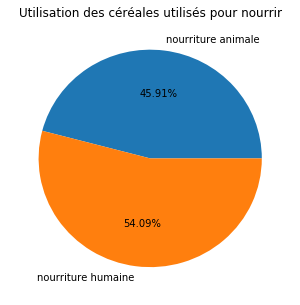

In [217]:
plt.figure(figsize = (5,5))
plot = plt.pie(
    [prop_anim_alim, 1-prop_anim_alim], 
    labels=['nourriture animale', 'nourriture humaine'],
    autopct = lambda x: str(round(x, 2)) + '%'
)
display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 11
Utilisation des céréales déstinés à l'alimentation :
"""))
plot = plt.title('Utilisation des céréales utilisés pour nourrir')

<div class="alert alert-info">
*début de la question 12*

Sélectionnez parmi les données des bilans alimentaires les informations relatives aux pays dans lesquels la FAO recense des personnes en sous-nutrition, pour une année choisie.

In [218]:
df_1 = produit_elem_df.dropna(subset=['pop_ss_alim'])

Repérez les 15 produits les plus exportés par ce groupe de pays sur l'année choisie.

In [219]:
df_2 = df_1[['code_produit', 'produit', 'export__ktonne']]\
.groupby(by=['code_produit', 'produit']).sum().reset_index()\
.sort_values(by='export__ktonne', ascending=False)

produit_export_par_pays_ss_alim = df_2.produit[:15]

In [220]:
produit_export_par_pays_ss_alim

38         Huile de Palme
2                    Maïs
9                  Manioc
95       Riz (Eq Blanchi)
16          Sucre Eq Brut
0                     Blé
47        Légumes, Autres
52                Bananes
58         Fruits, Autres
96     Lait - Excl Beurre
22                   Soja
85    Poissons Pelagiques
45                Tomates
54                 Pommes
48    Oranges, Mandarines
Name: produit, dtype: object

Parmi les données des bilans alimentaires au niveau mondial, sélectionnez les 200 plus grandes importations de ces produits (1 importation = une quantité d'un produit donné importée par un pays donné sur l'année choisie)

In [221]:
df_3 = produit_elem_df.loc[
    produit_elem_df['produit'].isin(produit_export_par_pays_ss_alim),
   #['pays', 'produit', 'import__ktonne']
]\
.sort_values('import__ktonne', ascending=False)\
[:200]

Groupez ces importations par produit, afin d'avoir une table contenant 1 ligne pour chacun des 15 produits. Ensuite, calculez pour chaque produit les 2 quantités suivantes :
- le ratio entre la quantité destinés aux "Autres utilisations" (Other uses) et la disponibilité intérieure.
- le ratio entre la quantité destinée à la nourriture animale et la quantité destinée à la nourriture (animale + humaine)

In [222]:
## pays | produit | autre_util__ktonne | disp_inter__ktonne | alim_pr_anim__ktonne | nourriture__ktonne
df_4 = df_3[['pays', 'produit','autre_util__ktonne','disp_inter__ktonne','alim_pr_anim__ktonne','nourriture__ktonne']]

## on fait le groupby produit : les pays sautent
## produit | autre_util__ktonne | disp_inter__ktonne | alim_pr_anim__ktonne | nourriture__ktonne
df_5 = df_4.groupby('produit').sum().reset_index() # on utilise une somme car on ne manipule que des quantité

# Comment sont utilisé (dans les pays importateurs ) les 15 produits les plus éxporté par les pays sous alimenté ?
# ce calcul est basé sur les 200 plus grosses importations de ces 15 produits.

In [223]:
## produit | ratio__autre_util__disp_inter | ratio__alim_pr_anim__nourriture_anim_hum
df_6 = df_5.copy()
df_6['ratio__autre_util__disp_inter'] = df_6['autre_util__ktonne'] / df_6['disp_inter__ktonne']
df_6['ratio__alim_pr_anim__nourriture_anim_hum'] = df_6['alim_pr_anim__ktonne'] / (df_6['alim_pr_anim__ktonne'] + df_6['nourriture__ktonne'])

df_6 = df_6[['produit', 'ratio__autre_util__disp_inter', 'ratio__alim_pr_anim__nourriture_anim_hum']]

<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 12 **
    <a id="question-12" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    Donnez les 3 produits qui ont la plus grande valeur pour chacun des 2 ratios (vous aurez donc 6 produits à citer)
  </div>
</div>

In [224]:
ratio__autre_util__disp_inter__3max = df_6[['produit', 'ratio__autre_util__disp_inter']]\
.sort_values('ratio__autre_util__disp_inter', ascending=False)\
[:3]#.produit.values

ratio__alim_pr_anim__nourriture_anim_hum__3max = df_6[['produit', 'ratio__alim_pr_anim__nourriture_anim_hum']]\
.sort_values('ratio__alim_pr_anim__nourriture_anim_hum', ascending=False)\
[:3].produit.values

In [225]:
ratio__autre_util__disp_inter__3max

,produit,ratio__autre_util__disp_inter
3,Huile de Palme,0.724803
6,Manioc,0.302335
7,Maïs,0.259771


In [226]:
display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 12
Quelles sont, parles produits les plus exporté par les pays *sous alimentés*
<br> <br>
&rArr; $ autre\ utilisation \over disponibilité\ intérieur $ : **{', '.join(ratio__autre_util__disp_inter__3max)}**
<br> <br>
&rArr; $ aliments\ pour\ animaux \over nourriture\ (humaine + animale) $ : **{', '.join(ratio__alim_pr_anim__nourriture_anim_hum__3max)}**
"""))


<div class="alert alert-success">
#### Réponse 12
Quelles sont, parles produits les plus exporté par les pays *sous alimentés*
<br> <br>
&rArr; $ autre\ utilisation \over disponibilité\ intérieur $ : **produit, ratio__autre_util__disp_inter**
<br> <br>
&rArr; $ aliments\ pour\ animaux \over nourriture\ (humaine + animale) $ : **Maïs, Poissons Pelagiques, Soja**


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 13 **
    <a id="question-13" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    Combien de tonnes de céréales pourraient être libérées si les USA diminuaient leur production de produits animaux de 10% ?
  </div>
</div>

On calcule la masse de céréales utilisée aux USA pour nourrir les animaux

In [227]:
qt_cere_pr_anim_ktonne = produit_elem_df.loc[
    (produit_elem_df.pays == "États-Unis d'Amérique")
    & (produit_elem_df.code_produit.isin(code_cerales)),
    "alim_pr_anim__ktonne"
].sum()

on prend 10% de cette valeur

In [228]:
reponse = qt_cere_pr_anim_ktonne * 0.1

#### Extra : Combien de personnes pourrait-on nourrir avec cette quantité ?

In [229]:
usa_cere = produit_elem_df.loc[
    (produit_elem_df.pays == "États-Unis d'Amérique")
    & (produit_elem_df.code_produit.isin(code_cerales)),
    ['alim_pr_anim__ktonne', 'ratio_e_pds__kcal_kg', 'prc_prot']
]

In [230]:
usa_cere['alim_pr_anim__kcal'] = usa_cere['alim_pr_anim__ktonne'] * 1e6 * usa_cere['ratio_e_pds__kcal_kg']

In [236]:
qt_cere_pr_anim_kcal = usa_cere['alim_pr_anim__kcal'].sum()

In [237]:
# 10% des céréales utilisé pour nourrir les animaux pourrait nourrir combien d'humains ?
nb_per_nrsable = (qt_cere_pr_anim_kcal*0.1) / (BESOIN_QUOTIDIEN['kcal'] * NB_JOUR_ANNEE)

In [238]:
display(Markdown(f"""
<div class="alert alert-success">
#### Réponse 13
&rArr; Si les USA diminuaient leur **production animale de 10%**,
Ils libéreraient **{reponse/1e3:.0f} Ktonnes de céréales**. <br> <br>
*Cela permettrait de subvenir aux besoins caloriques de **{nb_per_nrsable / 1e6:.0f} Millions** de personnes*.
"""))


<div class="alert alert-success">
#### Réponse 13
&rArr; Si les USA diminuaient leur **production animale de 10%**,
Ils libéreraient **14 Ktonnes de céréales**. <br> <br>
*Cela permettrait de subvenir aux besoins caloriques de **42 Millions** de personnes*.


<div class="panel panel-info">

  <div class="panel-heading" >
    **Question 14 **
    <a id="question-14" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>
  </div>
  
  <div class="panel-body">
    En Thaïlande, quel proportion de manioc est exportée ? Quelle est la proportion de personnes en sous-nutrition?
  </div>
</div>

In [239]:
# pays='Thaïlande', code_pays=216
# produit='Manioc' code_produit=2532

# on récupere la ligne qui correspond a Thailand / Manioc sous forme de serie
sr = produit_elem_df.loc[
    (produit_elem_df['pays'] == 'Thaïlande')
    &(produit_elem_df['produit'] == 'Manioc'),
].iloc[0]

proportion_manioc_export = sr['export__ktonne'] / sr['prod__ktonne']
proportion_per_ss_alim = sr['pop_ss_alim'] / sr['pop']

In [240]:
display(Markdown(f"""

<div class="alert alert-success">
#### Réponse 14

En Thaïlande, **{proportion_manioc_export*100:.0f}%** du manioc produit est exporté alors que
**{proportion_per_ss_alim*100:.0f}%** de la population est sous-alimentée.
"""))



<div class="alert alert-success">
#### Réponse 14

En Thaïlande, **83%** du manioc produit est exporté alors que
**9%** de la population est sous-alimentée.
